<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Upsampling" data-toc-modified-id="Upsampling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Upsampling</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Downsampling</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score


from sklearn.pipeline import Pipeline, make_pipeline

In [2]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [3]:
df = pd.read_csv("/datasets/Churn.csv")

In [4]:
display(df.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Признаки:

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак:

- Exited — факт ухода клиента

In [5]:
# удалим ненужные в данной задаче столбцы
df=df.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,9091.0,4.997690,2.894723,0.00,2.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [7]:
#Заполнение пропусков
df['Tenure']=df['Tenure'].fillna(0).astype('int8')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int8   
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(6), int8(1), object(2)
memory usage: 791.1+ KB


Теперь можем приступать к исследованию задачи

## Исследование задачи

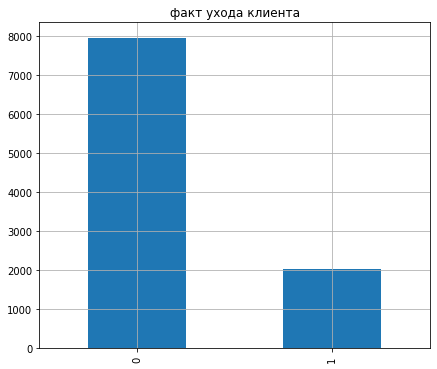

In [9]:
df['Exited'].value_counts().plot(kind='bar',grid=True,figsize=(7,6),title='факт ухода клиента')
plt.show()

Из графика отчетливо видим дисбаланс классов - 4 к 1

Необходимо подготовить признаки. Применим метод OHE и масштабирование

In [10]:
df_ohe=pd.get_dummies(df,drop_first=True)

In [12]:
features = df_ohe.drop("Exited", axis=1)
target = df["Exited"]

Выделим обучающую, валидационную и тестовую выборки. 

In [13]:
features_train, features_test0, target_train, target_test0 = train_test_split(features, target, 
                                                                              test_size=0.4, 
                                                                              random_state=1)

In [14]:
features_valid, features_test, target_valid, target_test = train_test_split(features_test0, target_test0, 
                                                                              test_size=0.5, 
                                                                              random_state=1)

In [15]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [16]:
scaler = MinMaxScaler()
scaler.fit(features_train[numeric])

MinMaxScaler()

In [17]:
features_train_scaled = features_train.copy(deep=True)
features_train_scaled[numeric] = scaler.transform(features_train[numeric])

features_valid_scaled = features_valid.copy(deep=True)
features_valid_scaled[numeric] = scaler.transform(features_valid[numeric])

features_test_scaled = features_test.copy(deep=True)
features_test_scaled[numeric] = scaler.transform(features_test[numeric])

Logistic Regression

In [18]:
%%time

model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train_scaled, target_train)
predictions = model.predict(features_valid_scaled)
print("Accuracy:", accuracy_score(predictions, target_valid))
print("F1:", f1_score(predictions, target_valid))

Accuracy: 0.812
F1: 0.32616487455197135
CPU times: user 44.4 ms, sys: 17.1 ms, total: 61.5 ms
Wall time: 69.5 ms


Random Forest

In [19]:
%%time

model_RF = RandomForestClassifier()
param_grid = { 
    'n_estimators': [10, 20, 30, 40, 50],
    'max_depth' : [5,7,9,11,13,15]
}

CV_model_RF = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv=5)
CV_model_RF.fit(features_train_scaled, target_train)

predictions = CV_model_RF.best_estimator_.predict(features_valid_scaled)
print(CV_model_RF.best_estimator_)
print("accuracy:", accuracy_score(predictions, target_valid))
print("F1:", f1_score(predictions, target_valid))

RandomForestClassifier(max_depth=11, n_estimators=40)
accuracy: 0.865
F1: 0.5945945945945946
CPU times: user 30.9 s, sys: 105 ms, total: 31 s
Wall time: 31.3 s


Модель случайного леса показывает лучшие результаты. При глубине=13 и количество наблюдателей=30 - метрика f1=0.59. Далее будем работать именно с этой моделью.

## Борьба с дисбалансом

### Upsampling

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [21]:
features_upsampled_train, target_upsampled_train = upsample(features_train_scaled, target_train, 4)

In [22]:
%%time

#CV_model_RF = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv=5)
#CV_model_RF.fit(features_upsampled_train, target_upsampled_train)

#predictions = CV_model_RF.best_estimator_.predict(features_valid)
#print("accuracy:", accuracy_score(predictions, target_valid))
#print("F1:", f1_score(predictions, target_valid))

def score_model(model, params, cv=None):
    if cv is None:
        cv = KFold(n_splits=5, random_state=42)
    scores = []

    for train_fold_index, val_fold_index in cv.split(features_train_scaled, target_train):
        X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(features_train_scaled, target_train, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
        
        
        

        X_train_fold_upsample, y_train_fold_upsample = upsample(X_train_fold, y_train_fold, 4)
        model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        score = f1_score(model_obj.predict(X_val_fold), y_val_fold)
        scores.append(score)
    return np.array(scores)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [27]:
score_tracker = []
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        example_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'random_state': 12345
        }
        example_params['f1'] = score_model(RandomForestClassifier, 
                                               example_params, cv=kf).mean()
        score_tracker.append(example_params)

In [28]:
sorted(score_tracker, key=lambda x: x['f1'], reverse=True)

[{'n_estimators': 40,
  'max_depth': 9,
  'random_state': 12345,
  'f1': 0.5918173168411037},
 {'n_estimators': 50,
  'max_depth': 9,
  'random_state': 12345,
  'f1': 0.5876777251184834},
 {'n_estimators': 50,
  'max_depth': 11,
  'random_state': 12345,
  'f1': 0.5873836608066184},
 {'n_estimators': 40,
  'max_depth': 7,
  'random_state': 12345,
  'f1': 0.5873015873015873},
 {'n_estimators': 30,
  'max_depth': 7,
  'random_state': 12345,
  'f1': 0.587188612099644},
 {'n_estimators': 30,
  'max_depth': 11,
  'random_state': 12345,
  'f1': 0.586171310629515},
 {'n_estimators': 50,
  'max_depth': 7,
  'random_state': 12345,
  'f1': 0.5842293906810035},
 {'n_estimators': 30,
  'max_depth': 9,
  'random_state': 12345,
  'f1': 0.5829428303655109},
 {'n_estimators': 20,
  'max_depth': 11,
  'random_state': 12345,
  'f1': 0.5823045267489712},
 {'n_estimators': 20,
  'max_depth': 5,
  'random_state': 12345,
  'f1': 0.5811965811965811},
 {'n_estimators': 30,
  'max_depth': 5,
  'random_state': 1

The best estimator: 

{'n_estimators': 40,
  'max_depth': 9,
  'random_state': 12345,
  'f1': 0.5918173168411037}

In [29]:
rf = RandomForestClassifier(n_estimators=40, max_depth=9, random_state=12345)
rf.fit(features_upsampled_train, target_upsampled_train)
f1_score(target_valid, rf.predict(features_valid_scaled))

0.6219895287958116

In [30]:
probabilities_valid = rf.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8636159871472218


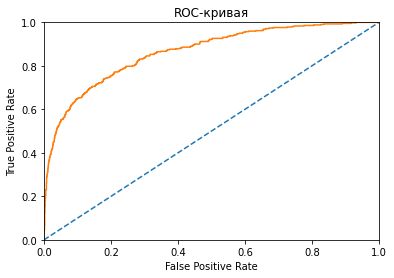

In [31]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Downsampling

In [32]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [33]:
features_downsampled_train, target_downsampled_train = downsample(features_train_scaled, target_train, 0.5)

In [34]:
%%time

#CV_model_RF = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv=5)
#CV_model_RF.fit(features_downsampled_train, target_downsampled_train)
#
#predictions = CV_model_RF.best_estimator_.predict(features_valid)
#print("accuracy:", accuracy_score(predictions, target_valid))
#print("F1:", f1_score(predictions, target_valid))

def score_model_downsampled(model, params, cv=None):
    if cv is None:
        cv = KFold(n_splits=5, random_state=42)
    scores = []

    for train_fold_index, val_fold_index in cv.split(features_train_scaled, target_train):
        X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(features_train_scaled, target_train, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
        
        
        

        X_train_fold_downsample, y_train_fold_downsample = downsample(X_train_fold, y_train_fold, 0.5)
        model_obj = model(**params).fit(X_train_fold_downsample, y_train_fold_downsample)
        score = f1_score(model_obj.predict(X_val_fold), y_val_fold)
        scores.append(score)
    return np.array(scores)



CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


In [35]:
score_tracker_downsampled = []
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        example_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'random_state': 12345
        }
        example_params['f1'] = score_model_downsampled(RandomForestClassifier,example_params, cv=kf).mean()
        score_tracker_downsampled.append(example_params)

In [36]:
sorted(score_tracker_downsampled, key=lambda x: x['f1'], reverse=True)

[{'n_estimators': 30,
  'max_depth': 9,
  'random_state': 12345,
  'f1': 0.6006528835690967},
 {'n_estimators': 40,
  'max_depth': 15,
  'random_state': 12345,
  'f1': 0.5958333333333334},
 {'n_estimators': 50,
  'max_depth': 11,
  'random_state': 12345,
  'f1': 0.5944206008583691},
 {'n_estimators': 30,
  'max_depth': 13,
  'random_state': 12345,
  'f1': 0.5895833333333332},
 {'n_estimators': 30,
  'max_depth': 11,
  'random_state': 12345,
  'f1': 0.586864406779661},
 {'n_estimators': 40,
  'max_depth': 13,
  'random_state': 12345,
  'f1': 0.5867507886435331},
 {'n_estimators': 30,
  'max_depth': 7,
  'random_state': 12345,
  'f1': 0.5859728506787331},
 {'n_estimators': 50,
  'max_depth': 9,
  'random_state': 12345,
  'f1': 0.5852585258525852},
 {'n_estimators': 20,
  'max_depth': 11,
  'random_state': 12345,
  'f1': 0.5850052798310454},
 {'n_estimators': 50,
  'max_depth': 13,
  'random_state': 12345,
  'f1': 0.5850052798310454},
 {'n_estimators': 50,
  'max_depth': 7,
  'random_stat

The best estimator: 

{'n_estimators': 30,
  'max_depth': 9,
  'random_state': 12345,
  'f1': 0.6006528835690967}

In [37]:
rf = RandomForestClassifier(n_estimators=30, max_depth=9, random_state=12345)
rf.fit(features_downsampled_train, target_downsampled_train)
f1_score(target_valid, rf.predict(features_valid_scaled))

0.6348808030112923

In [38]:
probabilities_valid = rf.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8565540293549992


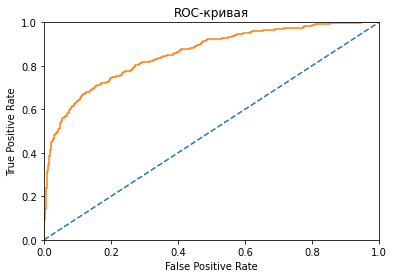

In [39]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Метод уменьшения выборки показал большую эффективность по сравнению с методов увеличением выборки. Величина f1 составила 0.63 vs 0.62, но при этом мы видим, что оба метода работают, в обоих случаях метрики стали лучше. 

## Тестирование модели

In [40]:
predictions = rf.predict(features_test_scaled)
print("Accuracy:", accuracy_score(predictions, target_test))
print("F1:", f1_score(predictions, target_test))

Accuracy: 0.855
F1: 0.611260053619303


In [41]:
probabilities_test = rf.predict_proba(features_test_scaled)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

0.8536038276069922


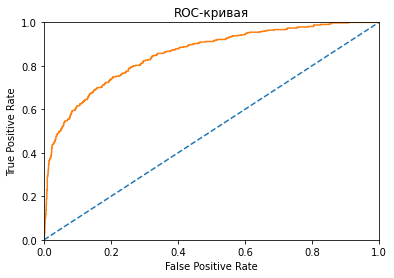

In [42]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Выводы

- Проведен анализ данных. Выявлен дисбаланс данных ~ 4 к 1
- Провели подготовку признаков используя методы OHE и масштабирования
- Исселодвали модели на дисбалансных данных. Лучший результат показала модель Случайный лес. f1 = 0.59
- Провели увеличение и уменьшение выборки. Метод уменьшения оказался более эффективным. f1 = 0.63
- На тестовой выборке результат f1 составил 0.61. Показатель AUC-ROC = 0.85